### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

# README

Each cell is labelled/grouped using the text cells above them. This README hopefully allows you to reproduce our results by running the stated cells in that specific order.

## GLoVe

- Start
- Load Data
- Training and Evaluation Helpers
- Helper Functions
- Models
- Initialisation & Processing - Prepare the data for training, assign hyperparameters, initialise the models.
- Initialisation & Processing - Extract and parse the edited words and sentences
- Training - Models (Approach 1) - GLoVe Models - GLoVe-specific Training
- GLoVe Testing


## BERT Single w/ Attention

- Start
- Load Data
- Training and Evaluation Helpers
- Helper Functions
- Models
- Initialisation & Processing - Prepare the data for training, assign hyperparameters, initialise the models.
- Initialisation & Processing - Extract and parse the edited words and sentences
- Initialisation & Processing - Prepare Bert and RoBerta specfic Preprocessing
- BERT Testing
- Training - Models (Approach 1) - Bert Training with Single Sentence


## BERT Single w/ Attention, Freeze

- Start
- Load Data
- Training and Evaluation Helpers
- Helper Functions
- Models
- Initialisation & Processing - Prepare the data for training, assign hyperparameters, initialise the models.
- Initialisation & Processing - Extract and parse the edited words and sentences
- Initialisation & Processing - Prepare Bert and RoBerta specfic Preprocessing
- BERT Testing
- Training - Models (Approach 1) - Bert Training with Single Sentence and Freezing


## BERT Double

- Start
- Load Data
- Training and Evaluation Helpers
- Helper Functions
- Models
- Initialisation & Processing - Prepare the data for training, assign hyperparameters, initialise the models.
- Initialisation & Processing - Extract and parse the edited words and sentences
- Initialisation & Processing - Prepare Bert and RoBerta specfic Preprocessing
- BERT Testing
- Training - Models (Approach 1) - Bert Training with Double Sentences


## BertForSequenceClassification

- Start
- Load Data
- Training and Evaluation Helpers
- Helper Functions
- Models
- Initialisation & Processing - Prepare the data for training, assign hyperparameters, initialise the models.
- Initialisation & Processing - Extract and parse the edited words and sentences
- Initialisation & Processing - Prepare Bert and RoBerta specfic Preprocessing
- BERT Testing
- Training - Models (Approach 1) - Bert with Sequence Classification with Both Sentences


## RoBERTa

- Start
- Load Data
- Training and Evaluation Helpers
- Helper Functions
- Models
- Initialisation & Processing - Prepare the data for training, assign hyperparameters, initialise the models.
- Initialisation & Processing - Extract and parse the edited words and sentences
- Initialisation & Processing - Prepare Bert and RoBerta specfic Preprocessing
- RoBERTa Testing
- Training - Models (Approach 1) - RoBERTa Single


## RoBERTa Double

- Start
- Load Data
- Training and Evaluation Helpers
- Helper Functions
- Models
- Initialisation & Processing - Prepare the data for training, assign hyperparameters, initialise the models.
- Initialisation & Processing - Extract and parse the edited words and sentences
- Initialisation & Processing - Prepare Bert and RoBerta specfic Preprocessing
- RoBERTa Testing
- Training - Models (Approach 1) - RoBERTa Double




# Start



In [29]:
!pip install transformers
!pip install torch
!pip install skorch

In [30]:
# Imports
import sys
import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, RobertaTokenizer, AdamW, BertConfig
from transformers import BertModel, BertForSequenceClassification,  RobertaModel
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import nltk
import codecs
import gc

In [31]:
# Setting random seed and device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
  print("Using GPU.")
else:
  print("Using CPU.")

def reset_seed(SEED=1):
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  np.random.seed(SEED)

reset_seed()

Using GPU.


# Load Data

In [32]:
# Load data

!wget -O train.csv https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f&export=download
!wget -O dev.csv https://drive.google.com/u/0/uc?id=1rY6A0cN_cxAMK3aMHlTFWxhbcLFomvQL&export=download
!wget -O test.csv https://drive.google.com/u/0/uc?id=1JBovQj-Tki8k2yJxLFxexUvs3ahrCneu&export=download

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./dev.csv')
true_test_df = pd.read_csv('./test.csv')

--2021-03-02 13:49:05--  https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving drive.google.com (drive.google.com)... 74.125.20.139, 74.125.20.102, 74.125.20.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vf7u4gu1voud67vh5tji3h23gfevkqp0/1614692925000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f [following]
--2021-03-02 13:49:05--  https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vf7u4gu1voud67vh5tji3h23gfevkqp0/1614692925000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)|74.125

# Training and Evaluation Helpers
Here we have the helper functions that define the training and evaluation cycle, with specialised functions for models which require inputs other than the traditional sentence + grade input (e.g. Bert).

In [33]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, loss_fn, optimizer, freeze=None):
  """
  Training loop for the model, which calls on eval to evaluate after each epoch
  """
  training_stats = []
  print("Training model.")

  frozen = False
  if (freeze != None):
    assert (freeze > 0 and number_epoch >= freeze)
    model.freeze_embeddings()    
    frozen = True

  for epoch in range(1, number_epoch+1):
    model.train()
    epoch_loss = 0
    epoch_sse = 0
    no_observations = 0  # Observations used for training so far

    if (frozen and epoch > freeze):
      model.unfreeze_embeddings()
      frozen = False

    for feature, target in train_iter:
      # for RNN:
      model.batch_size = target.shape[0]
      no_observations = no_observations + target.shape[0]
      model.hidden = model.init_hidden()

      if torch.is_tensor(feature):
        feature = feature.to(device)
      if torch.is_tensor(target):
        target  = target.to(device)

      predictions = model(feature).squeeze(1)
      optimizer.zero_grad()
      loss = loss_fn(predictions, target)
      sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse

      loss = loss.detach().cpu().item()
      del loss
      gc.collect()

    valid_loss, valid_mse, __, __ = eval(dev_iter, model, loss_fn)
    epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations

    print('| Epoch: %.2d | Train Loss: %.4f | Train RMSE: %.4f | Val. Loss: %.4f | Val. RMSE: %.4f |' % (
      epoch, epoch_loss, epoch_mse**0.5, valid_loss, valid_mse**0.5
    ))

    training_stats.append({
            'epoch': epoch,
            'train_loss': epoch_loss,
            'train_rmse': epoch_mse**0.5,
            'val_loss': valid_loss,
            'val_rmse': valid_mse**0.5
    })

  return training_stats

In [34]:
# Used to get predictions for evaluation
def get_predictions(test_iter, model):
  """
  Training loop for the model, which calls on eval to evaluate after each epoch
  """

  preds = np.array([])
  pred_ids = np.array([])
  model.eval()
  for feature, ids in test_iter:
    # for RNN:
    model.batch_size = ids.shape[0]
    model.hidden = model.init_hidden()

    if torch.is_tensor(feature):
        feature = feature.to(device)
    predictions = model(feature).squeeze(1)
    preds = np.concatenate((preds, predictions.detach().cpu().numpy()))
    pred_ids = np.concatenate((pred_ids, ids.detach().cpu().numpy()))

  return np.array(preds), np.array(pred_ids)

In [35]:
# We evaluate performance on our dev set
def eval(data_iter, model, loss_fn):
  """
  Evaluating model performance on the dev set
  """
  model.eval()
  epoch_loss = 0
  epoch_sse = 0
  pred_all = []
  trg_all = []
  no_observations = 0

  with torch.no_grad():
    for batch in data_iter:
      feature, target = batch
      if torch.is_tensor(feature):
        feature = feature.to(device)
      if torch.is_tensor(target):
        target  = target.to(device)

      # for RNN:
      model.batch_size = target.shape[0]
      no_observations = no_observations + target.shape[0]
      model.hidden = model.init_hidden()

      predictions = model(feature).squeeze(1)
      loss = loss_fn(predictions, target)

      # We get the mse
      pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
      sse, __ = model_performance(pred, trg)

      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse
      pred_all.extend(pred)
      trg_all.extend(trg)

  return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [36]:
# How we print the model performance
def model_performance(output, target, print_output=False):
  """
  Returns SSE and MSE per batch (printing the MSE and the RMSE)
  """
  sq_error = (output - target)**2
  sse = np.sum(sq_error)
  mse = np.mean(sq_error)
  rmse = np.sqrt(mse)

  if print_output:
    print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

  return sse, mse

In [37]:
from gensim.models import Word2Vec
import multiprocessing

# Train our own word embedding
def train_word_embedding(sentences, e_dim=100, window=5, negative=15, iter=10, workers=multiprocessing.cpu_count()):
  return Word2Vec(sentences, size=e_dim, window=5, negative=15, iter=10, workers=multiprocessing.cpu_count())

In [38]:
def score_task_1(truth_loc, prediction_loc):
    truth = pd.read_csv(truth_loc, usecols=['id','meanGrade'])
    pred = pd.read_csv(prediction_loc, usecols=['id','pred'])

    assert(sorted(truth.id) == sorted(pred.id)),"ID mismatch between ground truth and prediction!"
    
    data = pd.merge(truth,pred)
    rmse = np.sqrt(np.mean((data['meanGrade'] - data['pred'])**2))
    
    print("RMSE = %.3f" % rmse)

# Helper Functions

Helper functions for preprocessing or during model training.

In [39]:
def create_vocab(data):
  """
  Creating a corpus of all the tokens used
  """
  tokenized_corpus = [] # Let us put the tokenized corpus in a list

  for sentence in data:
    tokenized_sentence = []

    for token in sentence.split(' '): # simplest split is
      tokenized_sentence.append(token)

    tokenized_corpus.append(tokenized_sentence)

  # Create single list of all vocabulary
  vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
          vocabulary.append(token)

  return vocabulary, tokenized_corpus

In [40]:
def get_sentences(df, og_label='original', edit_label='edit'):
  """
  Extract the original and new sentences + words from a dataframe
  """
  p = r"<(.*)\/>"
  replace_regex = re.compile(p)
  og_word = []
  new_word = []
  og_sentences = []
  new_sentences = []

  for s, w in df[[og_label, edit_label]].itertuples(index=False,name=None):
    tokens = s.split(' ') # For each sentence get the words
    m = replace_regex.search(str(s)) # Get the word to replace

    assert not m is None # Couldn't regex match the replacement word

    og_word.append(m.group(1))
    new_word.append(w)
    og_sentences.append(replace_regex.sub( m.group(1), s))
    new_sentences.append(replace_regex.sub(w, s))
  
  return og_sentences, new_sentences, og_word, new_word


In [41]:
def softmax_mask(batch, mask):
    normalizing_mask = torch.Tensor([[float('-inf') if token == 0 else 0 for token in entry] for entry in mask]).to(device)
    return torch.nn.functional.softmax(batch + normalizing_mask, dim=-1)

def padd_mask(batch):
    return torch.Tensor([[0 if token == 0 else 1 for token in entry] for entry in batch]).to(device)

def collate_fn_padd(batch):
  '''
  We add padding to our minibatches and create tensors for our model
  '''
  batch_labels = [l for f, l in batch]
  batch_features = [f for f, l in batch]
  batch_features_len = [len(f) for f, l in batch]
  seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

  for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

  batch_labels = torch.FloatTensor(batch_labels)
  return seq_tensor, batch_labels

class Task1Dataset(Dataset):
  def __init__(self, train_data, labels):
    self.x_train = train_data
    self.y_train = labels

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, item):
    return self.x_train[item], self.y_train[item]

def collate_fn_padd_features(batch):
  '''
  We add padding to our minibatches and create tensors for our model
  '''
  batch_features = [f for f in batch]
  batch_features_len = [len(f) for f in batch]
  seq_tensor = torch.zeros((len(batch), max(batch_features_len)), dtype=torch.long)

  for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

  return seq_tensor

def collate_fn_padd_labels(batch):
  '''
  We add padding to our minibatches and create tensors for our model
  '''
  sequences = [f for f, l in batch]
  batch_labels = torch.FloatTensor([l for f, l in batch])
  return sequences, batch_labels

In [42]:
def encode_edited(edited_sentence, grades, tokenizer):
  encoded_data = []
  attention_data = []

  for sentence in edited_sentence:
    encoded = tokenizer.encode_plus(sentence)
    encoded_data.append(encoded['input_ids'])

  # Split train dataset to train and validation sets
  train_val_dataset = Task1Dataset(encoded_data, grades)

  num_train = round(len(train_val_dataset) * train_proportion)
  num_val = len(train_val_dataset) - num_train
  train_dataset, val_dataset = random_split(train_val_dataset, (num_train, num_val))

  # Create dataloaders from the tokenised embeddings
  train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn_padd)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_padd)

  return train_dataloader, val_dataloader

def encode_both(og_sentence, edited_sentence, grades, tokenizer):
  encoded_data = []
  attention_data = []

  for og, new in zip(og_sentence, edited_sentence):
    encoded = tokenizer.encode_plus(og, text_pair=new)
    encoded_data.append(encoded['input_ids'])

  # Split train dataset to train and validation sets
  train_val_dataset = Task1Dataset(encoded_data, grades)

  num_train = round(len(train_val_dataset) * train_proportion)
  num_val = len(train_val_dataset) - num_train
  train_dataset, val_dataset = random_split(train_val_dataset, (num_train, num_val))

  # Create dataloaders from the tokenised embeddings
  train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn_padd)
  val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn_padd)

  return train_dataloader, val_dataloader

In [43]:
# Get average word length of edited sentence.
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [44]:
# Creates the vectorized sequences from our training corpus data
def get_word_vecs_dicts(joint_vocab, train_tokenized_corpus, word_vec=None, filename=None):
  # Either word_vec or filename must be defined
  assert not (filename is None and word_vec is None)

  wvecs = []
  word2idx = []
  idx2word = []
  index = 1

  if filename is None:
    for word in joint_vocab:
      if word in word_vec.vocab:
        vec = word_vec[word]
        wvecs.append(vec)
        word2idx.append((word, index))
        idx2word.append((index, word))
        index += 1
  else:
    with codecs.open(filename, 'r','utf-8') as f:
      for line in f.readlines():
        # Ignore the first line - first line typically contains vocab, dimensionality
        if len(line.strip().split()) > 3:
          word = line.strip().split()[0]
          if word in joint_vocab:
            (word, vec) = (word, list(map(float, line.strip().split()[1:])))
            wvecs.append(vec)
            word2idx.append((word, index))
            idx2word.append((index, word))
            index += 1

  wvecs = np.array(wvecs)
  word2idx = dict(word2idx)
  idx2word = dict(idx2word)
  cur_len = len(word2idx)
  vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

  # To avoid any sentences being empty (if no words match to our word embeddings)
  vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

  return wvecs, vectorized_seqs, cur_len

In [45]:
def encode_wvecs(vec_seqs, grades):
  # Create the dataset from vectorised sequences
  train_and_val = Task1Dataset(vec_seqs, grades)

  # Split based on the train_proportion hyperparameter
  train_examples = round(len(train_and_val) * train_proportion)
  val_examples = len(train_and_val) - train_examples
  train_dataset, val_dataset = random_split(train_and_val, (train_examples, val_examples))

  train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn_padd)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_padd)

  return train_loader, val_loader

# Models

Below are the model architectures that was at some point part of the testing of the code.

In [46]:
# Skeleton BiLSTM model
class BiLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
    super(BiLSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.device = device
    self.batch_size = batch_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    # The LSTM takes word embeddings as inputs, and outputs hidden states
    # with dimensionality hidden_dim.
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

    # The linear layer that maps from hidden state space to tag space
    self.hidden2label = nn.Linear(hidden_dim * 2, 1)
    self.hidden = self.init_hidden()

  def init_hidden(self):
    # Before we've done anything, we dont have any hidden state.
    # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
    # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
    return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
            torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

  def forward(self, sentence):
    embedded = self.embedding(sentence)
    embedded = embedded.permute(1, 0, 2)

    lstm_out, self.hidden = self.lstm(
        embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

    out = self.hidden2label(lstm_out[-1])
    return out

In [47]:
# RoBERTa
class RoBERTa(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, batch_size, device, 
               roberta_pretrained='roberta-base', output_hidden=False):
    super(RoBERTa, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.device = device
    self.batch_size = batch_size
    self.roberta = RobertaModel.from_pretrained(roberta_pretrained)
    self.output_hidden = output_hidden
    self.output_len = hidden_dim * 2 if output_hidden else 1

    # The LSTM takes word embeddings as inputs, and outputs hidden states with hidden_dim dimensions
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
    self.hidden2label = nn.Linear(hidden_dim * 2, 1)
    self.hidden = self.init_hidden()

    # Attention Layer?
    self.attn_linear = nn.Linear(hidden_dim * 2, 1)

  def freeze_embeddings(self):
        for param in self.roberta.base_model.parameters():
            param.requires_grad = False

  def unfreeze_embeddings(self):
      for param in self.roberta.base_model.parameters():
          param.requires_grad = True

  def init_hidden(self):
    # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
    return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
            torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

  # Run this or directly define the tokenizer attribute
  def init_preprocess(self, tokenizer):
    self.tokenizer = tokenizer

  # Used for multimodel sentence parsing
  def preprocess(self):
    
    # Assume sentences come in the form of (batch_size x sentences)
    def encode_batch(sentences):
      return collate_fn_padd_features(list(map(self.tokenizer.encode, sentences))).to(device)

    return encode_batch

  def get_embedded(self, sentence, grad=True):
    mask = (sentence != 0).type(torch.long)
    # Run the text through BERT, and collect all of the hidden states produced from all 12 layers
    if grad:
      # The last hidden-state is the first element of the output tuple
      out = self.roberta(sentence, mask)
      if 'last_hidden_state' in out:
        last_hidden_states = out['last_hidden_state']
      elif 'hidden_states' in out:
        last_hidden_states = out['hidden_states'][-1]
      else:
        # Couldn't extract hidden state
        assert False
    else:
      with torch.no_grad():
        out = self.roberta(sentence, mask)
        if 'last_hidden_state' in out:
          last_hidden_states = out['last_hidden_state']
        elif 'hidden_states' in out:
          last_hidden_states = out['hidden_states'][-1]
        else:
          # Couldn't extract hidden state
          assert False

    return last_hidden_states.type(torch.float32)

  def forward(self, sentence):
    mask = (sentence != 0).type(torch.long)
    # Get word embeddings. BERT base gives us 768 hidden parameters for each word.
    embedded = self.get_embedded(sentence) # (batch_size, max_len)

    # (max_len, batch_size, 768) -> (batch_size, max_len, directions * hidden_dim)
    lstm_out, self.hidden = self.lstm(embedded, self.hidden)

    # Attention Mechanism
    # Get similarity using DOT attention (i think)
    # (batch_size, max_len, directions * hidden_dim) -> (batch_size, max_len)
    att_out = self.attn_linear(lstm_out).squeeze(-1)
    # Get the attention weights for each token in a sentence (batch_size)
    # (batch_size, max_len) -> (batch_size, max_len)
    # att_out = torch.nn.functional.softmax(att_out, dim=-1)
    att_out = softmax_mask(att_out, mask)
    # Get sentence vector which is a weighted sum of token hidden states
    # (batch_size, max_len) -> (batch_size, directions * hidden_dim)
    att_out = torch.sum(att_out.unsqueeze(-1) * lstm_out, dim=1)

    # out = self.hidden2label(lstm_out[-1])
    return att_out if self.output_hidden else self.hidden2label(att_out)

In [48]:
# Bert
class BERT(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, batch_size, device, 
               bert_model=None, bert_pretrained='bert-base-uncased', output_hidden=False):
    super(BERT, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim
    self.device = device
    self.batch_size = batch_size
    self.bert = BertModel.from_pretrained(bert_pretrained).to(device) if bert_model == None else bert_model
    self.output_hidden = output_hidden
    self.output_len = hidden_dim * 2 if output_hidden else 1

    # The LSTM takes word embeddings as inputs, and outputs hidden states with hidden_dim dimensions
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
    self.hidden2label = nn.Linear(hidden_dim * 2, 1)
    self.hidden = self.init_hidden()

    # Attention Layer?
    self.attn_linear = nn.Linear(hidden_dim * 2, 1)

  def freeze_embeddings(self):
        for param in self.bert.base_model.parameters():
            param.requires_grad = False

  def unfreeze_embeddings(self):
      for param in self.bert.base_model.parameters():
          param.requires_grad = True

  def init_hidden(self):
    # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
    return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
            torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

  # Run this or directly define the tokenizer attribute
  def init_preprocess(self, tokenizer):
    self.tokenizer = tokenizer

  # Used for multimodel sentence parsing
  def preprocess(self):
    
    # Assume sentences come in the form of (batch_size x sentences)
    def encode_batch(sentences):
      return collate_fn_padd_features(list(map(self.tokenizer.encode, sentences))).to(device)

    return encode_batch

  def get_embedded(self, sentence, grad=True):
    mask = (sentence != 0).type(torch.long)
    # Run the text through BERT, and collect all of the hidden states produced from all 12 layers
    if grad:
      # The last hidden-state is the first element of the output tuple
      out = self.bert(sentence, mask)
      if 'last_hidden_state' in out:
        last_hidden_states = out['last_hidden_state']
      elif 'hidden_states' in out:
        last_hidden_states = out['hidden_states'][-1]
      else:
        # Couldn't extract hidden state
        assert False
    else:
      with torch.no_grad():
        out = self.bert(sentence, mask)
        if 'last_hidden_state' in out:
          last_hidden_states = out['last_hidden_state']
        elif 'hidden_states' in out:
          last_hidden_states = out['hidden_states'][-1]
        else:
          # Couldn't extract hidden state
          assert False

    return last_hidden_states.type(torch.float32)

  def forward(self, sentence):
    mask = (sentence != 0).type(torch.long)
    # Get word embeddings. BERT base gives us 768 hidden parameters for each word.
    embedded = self.get_embedded(sentence) # (batch_size, max_len)

    # (max_len, batch_size, 768) -> (batch_size, max_len, directions * hidden_dim)
    lstm_out, self.hidden = self.lstm(embedded, self.hidden)

    # Attention Mechanism
    # Get similarity using DOT attention (i think)
    # (batch_size, max_len, directions * hidden_dim) -> (batch_size, max_len)
    att_out = self.attn_linear(lstm_out).squeeze(-1)
    # Get the attention weights for each token in a sentence (batch_size)
    # (batch_size, max_len) -> (batch_size, max_len)
    # att_out = torch.nn.functional.softmax(att_out, dim=-1)
    att_out = softmax_mask(att_out, mask)
    # Get sentence vector which is a weighted sum of token hidden states
    # (batch_size, max_len) -> (batch_size, directions * hidden_dim)
    att_out = torch.sum(att_out.unsqueeze(-1) * lstm_out, dim=1)
    
    # out = self.hidden2label(lstm_out[-1])
    return att_out if self.output_hidden else self.hidden2label(att_out)

In [49]:
# Parallel Multi-model implementation
class MultiModel(nn.Module):
  def __init__(self, models, hidden_inits, batch_size, output_dims):
    '''
    A Wrapper which takes multiple models and gets their concatenated linearly transformed results

    Inputs:
    models (dict) -> key : model name (string), values : (nn.Module) model (with forward)
    hidden_inits (list) -> List of model names where init_hidden is required
    preprocess (dict) -> key : model name (string), values : (string -> token array) model's encoder for the sentence
    '''
    super(MultiModel, self).__init__()
    self.models = models
    self.hidden_inits = hidden_inits
    self.linear2label = nn.Linear(output_dims, 1)
    self.batch_size = batch_size

    # Requires the preprocess function which tokenizes a raw sentence to tokens
    for m in models.values():
      assert hasattr(m, 'preprocess')

  # For RNNs, init hiddens
  def init_hidden(self):
    for m in self.hidden_inits:
      self.models[m].batch_size = self.batch_size
      self.models[m].hidden = self.models[m].init_hidden()

  def forward(self, sentence):
    out_cat = []

    for m in self.models.values():
      encoded = m.preprocess()(sentence)
      preds = m(encoded)
      out_cat.append(preds)

    out = torch.cat(out_cat, dim=1)
    out = self.linear2label(out)
    return out

# Initialisation + Preprocessing
Prepare the data for training, assign hyperparameters, initialise the models.

In [50]:
# Hyperparameters
bert_type = 'bert-base-uncased'
rob_type  = 'roberta-base'
pad_len = 64

e_dim = 768
h_dim = 50

batch_size = 32
train_proportion = 0.8

#### Extract and parse the edited words and sentences

In [51]:
# Parse training and test data to tuple of original sentences, new sentences, etc.
x_og, x_new, x_og_word, x_new_word = get_sentences(train_df)
y_og, y_new, y_og_word, y_new_word = get_sentences(test_df)
x_grades = train_df['meanGrade']

# Insert these new sentences into the dataframe
train_df['editedSentence'] = x_new
train_df['replaceWord'] = x_og_word
test_df['editedSentence'] = y_new
test_df['replaceWord'] = y_og_word

### Prepare Bert and RoBerta specfic Preprocessing

In [52]:
# Get Tokenizer for preprocessing
bert_tokenizer = BertTokenizer.from_pretrained(bert_type, do_lower_case=True)
rob_tokenizer = RobertaTokenizer.from_pretrained(rob_type, do_lower_case=True)

# Get the dataloaders
bert_single_train_loader, bert_single_val_loader = encode_edited(x_new, x_grades, bert_tokenizer)
bert_both_train_loader, bert_both_val_loader = encode_both(x_og, x_new, x_grades, bert_tokenizer)
robert_single_train_loader, robert_single_val_loader = encode_edited(x_new, x_grades, rob_tokenizer)
robert_both_train_loader, robert_both_val_loader = encode_both(x_og, x_new, x_grades, rob_tokenizer)

### Prepare Feature Extraction

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

# This creates a new dataframe with the following extracted features.
def add_extracted_features(orig_df):
  # Create new dataframe.
  train_df = orig_df.copy(deep=True)
 
  # Average word length of edited sentence.
  train_df['avgWordLength'] = train_df['editedSentence'].apply(lambda x: avg_word(x))

  # Word counts per sentence.
  train_df['wordCounts'] = train_df['editedSentence'].apply(lambda x: len(str(x).split(" ")))
  
  # Character counts per edited sentence.
  train_df['charCounts'] = train_df['editedSentence'].str.len()  # This also includes spaces.

  # Number of stop words per edited sentence.
  train_df['numStopWords'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x in stop]))

  # Number of upper case words.
  train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isupper()])).value_counts()
  train_df['numUpperCase'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

  # Number of sentences with digits.
  train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()])).value_counts()
  train_df['numDigits'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

  # Number of sentences with hashtags.
  train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')])).value_counts()
  train_df['numHashtags'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

  return train_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer

def get_tfidf(sentences):
  count_vect = CountVectorizer(stop_words='english')
  train_counts_sentence = count_vect.fit_transform(sentences)
  transformer = TfidfTransformer().fit(train_counts_sentence)
  train_counts_sentence = transformer.transform(train_counts_sentence)
  return train_counts_sentence

#### BOW

In [ ]:
def get_bow(sentences):
  bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
  train_bow_sentence = bow.fit_transform(sentences)
  return train_bow_sentence

### Text Preprocessing

In [ ]:
from textblob import Word, TextBlob
nltk.download('wordnet')

# This creates a new processed dataframe.
def get_processed_df(orig_df):
  # Convert to lower case.
  processed = pd.DataFrame(orig_df['editedSentence'].apply(lambda x: " ".join(x.lower() for x in x.split())))
  processed['original'] = orig_df['original'].apply(lambda x: " ".join(x.lower() for x in x.split()))

  # Remove punctuation.
  processed['editedSentence'] = processed['editedSentence'].str.replace('[^\w\s]','')
  processed['original'] = processed['original'].str.replace('[^\w\s]','')

  # Remove stop words.
  processed['editedSentence'] = processed['editedSentence'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
  processed['original'] = processed['original'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # Lemmatization.
  processed['editedSentence'] = processed['editedSentence'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
  processed['original'] = processed['original'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
  
  # Extract sentiment.
  processed['sentiment'] = processed['editedSentence'].apply(lambda x: TextBlob(x).sentiment[0])
  processed['sentimentOrig'] = processed['original'].apply(lambda x: TextBlob(x).sentiment[0])
  processed['sentimentDiff'] = processed['sentiment'] - processed['sentimentOrig']

  return processed

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### Prepare Glove Preprocessing

### Word Embeddings

Here we prepare our own word embeddings for approach 2.

In [ ]:
# Parse training and test data to tuple of original sentences, new sentences, etc.
x_og, x_new, x_og_word, x_new_word = get_sentences(train_df)
y_og, y_new, y_og_word, y_new_word = get_sentences(test_df)
x_grades = train_df['meanGrade']

# Insert these new sentences into the dataframe
train_df['editedSentence'] = x_new
train_df['replaceWord'] = x_og_word
test_df['editedSentence'] = y_new
test_df['replaceWord'] = y_og_word

In [ ]:
processed_train = get_processed_df(add_extracted_features(train_df))
processed_test  = get_processed_df(add_extracted_features(test_df))

train_sentence = processed_train['editedSentence']
test_sentence = processed_test['editedSentence']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(train_sentence)
test_vocab, test_tokenized_corpus = create_vocab(test_sentence)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([train_sentence, test_sentence]))

print("Vocab created.")

Vocab created.


#### Brown Corpus

In [ ]:
from nltk.corpus import brown
nltk.download('brown')

brown_news_text = brown.words(categories='news')
brown_sentences = brown.sents()
brown_wv = train_word_embedding(brown_sentences).wv

brown_e_dim = 100
brown_wvecs, brown_vec_seqs, brown_input_dim = get_word_vecs_dicts(
    joint_vocab, training_tokenized_corpus, word_vec=brown_wv)
brown_train_loader, brown_test_loader = encode_wvecs(brown_vec_seqs, x_grades)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


#### Glove Embeddings (Pretrained)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-02-27 14:43:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-27 14:43:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-27 14:43:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
glove_e_dim = 100
glove_wvecs, glove_vec_seqs, glove_input_dim = get_word_vecs_dicts(
    joint_vocab, training_tokenized_corpus, filename='glove.6B.100d.txt')
glove_train_loader, glove_test_loader = encode_wvecs(glove_vec_seqs, x_grades)

# Training
Initialise optimisers and start training word embedding and models!

### Models (Approach 1)

### Testing Functions

These functions load in the test dataset and tests them at the end of training, and are not used during hyperparameter tuning (we have a validation set). There are different variants depending on which preprocessing is needed (single vs double sentence).

#### BERT Testing

In [53]:
# BERT Testing
def bert_single_test(model):
  test_encoded_data = []
  _, test_edited_sentences, _, _ = get_sentences(true_test_df)
  for sentence in test_edited_sentences:
    test_encoded = bert_tokenizer.encode(sentence, add_special_tokens=True)
    test_encoded_data.append(test_encoded)

  test_ids = true_test_df['id']
  test_dataset = Task1Dataset(test_encoded_data, test_ids)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_padd)

  predictions, pred_ids = get_predictions(test_dataloader, model)
  pd.DataFrame({'id': pred_ids, 'pred': predictions}).to_csv("./predictions.csv")
  score_task_1('./test.csv', './predictions.csv')

def bert_both_test(model):
  test_encoded_data = []
  test_original_sentences, test_edited_sentences, _, _ = get_sentences(true_test_df)
  for og, edited in zip(test_original_sentences, test_edited_sentences):
    test_encoded = bert_tokenizer.encode(og, text_pair=edited, add_special_tokens=True)
    test_encoded_data.append(test_encoded)

  test_ids = true_test_df['id']
  test_dataset = Task1Dataset(test_encoded_data, test_ids)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_padd)

  predictions, pred_ids = get_predictions(test_dataloader, model)
  pd.DataFrame({'id': pred_ids, 'pred': predictions}).to_csv("./predictions.csv")
  score_task_1('./test.csv', './predictions.csv')

#### RoBERTa Testing

In [54]:
# RoBERTa Testing
def roberta_single_test(model):
  test_encoded_data = []
  _, test_edited_sentences, _, _ = get_sentences(true_test_df)
  for sentence in test_edited_sentences:
    test_encoded = rob_tokenizer.encode(sentence, add_special_tokens=True)
    test_encoded_data.append(test_encoded)

  test_ids = true_test_df['id']
  test_dataset = Task1Dataset(test_encoded_data, test_ids)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_padd)

  predictions, pred_ids = get_predictions(test_dataloader, model)
  pd.DataFrame({'id': pred_ids, 'pred': predictions}).to_csv("./predictions.csv")
  score_task_1('./test.csv', './predictions.csv')

def roberta_both_test(model):
  test_encoded_data = []
  test_original_sentence, test_edited_sentences, _, _ = get_sentences(true_test_df)
  for og, edited in zip(test_original_sentence, test_edited_sentences):
    test_encoded = rob_tokenizer.encode(og, text_pair=edited, add_special_tokens=True)
    test_encoded_data.append(test_encoded)

  test_ids = true_test_df['id']
  test_dataset = Task1Dataset(test_encoded_data, test_ids)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_padd)

  predictions, pred_ids = get_predictions(test_dataloader, model)
  pd.DataFrame({'id': pred_ids, 'pred': predictions}).to_csv("./predictions.csv")
  score_task_1('./test.csv', './predictions.csv')

#### Multimodel Testing


In [55]:
# Multi-Model Testing
def multi_model_testing(model):
  _, test_edited_sentences, _, _ = get_sentences(true_test_df)

  test_ids = true_test_df['id']
  test_dataset = Task1Dataset(test_edited_sentences, test_ids)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_padd_labels)

  predictions, pred_ids = get_predictions(test_dataloader, model)
  pd.DataFrame({'id': pred_ids, 'pred': predictions}).to_csv("./predictions.csv")
  score_task_1('./test.csv', './predictions.csv')

#### Bert with Sequence Classification with Both Sentences

Warning: This model is large (12GB GPU Ram) and takes 21+ minutes per epoch.

In [ ]:
## Bert with Sequence Classification Training with Both Sentences
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 2e-5
epochs = 2
#=====================================#
# Load Pretrained Bert model for double sequence training
bert_double_pretrained = BertForSequenceClassification.from_pretrained(
    bert_type, 
    num_labels = 1,
    output_hidden_states = True
)
bert_double_pretrained = bert_double_pretrained.to(device) # Move to cuda if possible
bert_double_pretrained = bert_double_pretrained.double() # Convert classifier to regressor

# Initialise full model
model = BERT(e_dim, h_dim, batch_size, device, bert_double_pretrained).to(device)

# Optimizer and Scheduler setup
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=(epochs * len(bert_both_train_loader))
)

print("Model initialised.")

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

results = train(bert_both_train_loader, bert_both_val_loader, model, epochs, loss_fn, optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.3302 | Train RMSE: 0.5746 | Val. Loss: 0.2947 | Val. RMSE: 0.5429 |
| Epoch: 02 | Train Loss: 0.2472 | Train RMSE: 0.4972 | Val. Loss: 0.2788 | Val. RMSE: 0.5280 |


#### Bert Training with Double Sentences

In [30]:
## Bert Training with Double Sentence
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 15e-6
epochs = 2
#=====================================#
# Initialise full model
model = BERT(e_dim, h_dim, batch_size, device).to(device)

# Optimizer and Scheduler setup
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=(epochs * len(bert_single_train_loader))
)
print("Model initialised.")

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

results = train(bert_both_train_loader, bert_both_val_loader, model, epochs, loss_fn, optimizer)
bert_both_test(model)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.3367 | Train RMSE: 0.5803 | Val. Loss: 0.2899 | Val. RMSE: 0.5384 |
| Epoch: 02 | Train Loss: 0.2594 | Train RMSE: 0.5093 | Val. Loss: 0.2797 | Val. RMSE: 0.5289 |
RMSE = 0.535


#### Bert Training with Single Sentence

In [28]:
## Bert Training with Single Sentence
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 15e-6
epochs = 2
#=====================================#
# Initialise full model
model = BERT(e_dim, h_dim, batch_size, device).to(device)

# Optimizer and Scheduler setup
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=(epochs * len(bert_single_train_loader))
)
print("Model initialised.")

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

results = train(bert_single_train_loader, bert_single_val_loader, model, epochs, loss_fn, optimizer)
bert_single_test(model)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.3347 | Train RMSE: 0.5785 | Val. Loss: 0.3003 | Val. RMSE: 0.5480 |
| Epoch: 02 | Train Loss: 0.2607 | Train RMSE: 0.5106 | Val. Loss: 0.2789 | Val. RMSE: 0.5281 |
RMSE = 0.531


#### Bert Training with Single Sentence and Freezing

In [ ]:
## Bert Training with Single Sentence and Freezing
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 2e-5
epochs = 5
#=====================================#
# Initialise full model
model = BERT(e_dim, h_dim, batch_size, device).to(device)

# Optimizer and Scheduler setup
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=(epochs * len(bert_single_train_loader))
)
print("Model initialised.")

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

results = train(bert_single_train_loader, bert_single_val_loader, model, epochs, loss_fn, optimizer, freeze=3)
bert_single_test(model)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.7074 | Train RMSE: 0.8411 | Val. Loss: 0.3605 | Val. RMSE: 0.6004 |
| Epoch: 02 | Train Loss: 0.3517 | Train RMSE: 0.5930 | Val. Loss: 0.3455 | Val. RMSE: 0.5878 |
| Epoch: 03 | Train Loss: 0.3451 | Train RMSE: 0.5874 | Val. Loss: 0.3384 | Val. RMSE: 0.5817 |
| Epoch: 04 | Train Loss: 0.3150 | Train RMSE: 0.5612 | Val. Loss: 0.2835 | Val. RMSE: 0.5324 |
| Epoch: 05 | Train Loss: 0.2366 | Train RMSE: 0.4864 | Val. Loss: 0.2843 | Val. RMSE: 0.5332 |


#### RoBERTa Single

In [28]:
## Roberta Single Training
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 2e-5
epochs = 2
#=====================================#
# Initialise full model
model = RoBERTa(e_dim, h_dim, batch_size, device).to(device)

# Optimizer and Scheduler setup
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=(epochs * len(bert_single_train_loader))
)

print("Model initialised.")

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

results = train(robert_single_train_loader, robert_single_val_loader, model, epochs, loss_fn, optimizer)
roberta_single_test(model)


Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.3495 | Train RMSE: 0.5912 | Val. Loss: 0.3169 | Val. RMSE: 0.5630 |
| Epoch: 02 | Train Loss: 0.3100 | Train RMSE: 0.5568 | Val. Loss: 0.2833 | Val. RMSE: 0.5323 |
RMSE = 0.535


#### RoBERTa Double

In [ ]:
## Roberta Both Training
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 2e-5
epochs = 4
#=====================================#
# Initialise full model
model = RoBERTa(e_dim, h_dim, batch_size, device).to(device)

# Optimizer and Scheduler setup
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=(epochs * len(bert_both_train_loader))
)

print("Model initialised.")

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

results = train(robert_both_train_loader, robert_both_val_loader, model, epochs, loss_fn, optimizer)
roberta_both_test(model)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.3466 | Train RMSE: 0.5887 | Val. Loss: 0.3223 | Val. RMSE: 0.5677 |
| Epoch: 02 | Train Loss: 0.3210 | Train RMSE: 0.5665 | Val. Loss: 0.3085 | Val. RMSE: 0.5554 |
| Epoch: 03 | Train Loss: 0.2792 | Train RMSE: 0.5284 | Val. Loss: 0.3047 | Val. RMSE: 0.5520 |
| Epoch: 04 | Train Loss: 0.2359 | Train RMSE: 0.4857 | Val. Loss: 0.3016 | Val. RMSE: 0.5492 |


#### Multi-Modal Models

In [56]:
## Multi-Model Training
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 1e-5
epochs = 20
#=====================================#

# Create a simple sentence loader
simple_dataset = Task1Dataset(x_new, x_grades)
num_train = round(len(simple_dataset) * train_proportion)
num_val = len(simple_dataset) - num_train
train_dataset, val_dataset = random_split(simple_dataset, (num_train, num_val))

# Create dataloaders from the edited sentence
simple_train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn_padd_labels)
simple_val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_padd_labels)

# Setup the multiple models
output_dims = 0
model_r = RoBERTa(e_dim, h_dim, batch_size, device, output_hidden=True).to(device)
model_r.init_preprocess(RobertaTokenizer.from_pretrained(rob_type, do_lower_case=True))
output_dims += model_r.output_len

model_b = BERT(e_dim, h_dim, batch_size, device, output_hidden=True).to(device)
model_b.init_preprocess(BertTokenizer.from_pretrained(bert_type, do_lower_case=True))
output_dims += model_b.output_len

mod_dict = {'roberta': model_r, 'bert': model_b}
preprocess = ['roberta', 'bert']

model = MultiModel(mod_dict, preprocess, batch_size, output_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

print("Model initialised.")
results = train(simple_train_loader, simple_val_loader, model, epochs, loss_fn, optimizer)
multi_model_testing(model)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 1.2181 | Train RMSE: 1.1037 | Val. Loss: 1.1243 | Val. RMSE: 1.0604 |
| Epoch: 02 | Train Loss: 1.0890 | Train RMSE: 1.0436 | Val. Loss: 1.0037 | Val. RMSE: 1.0018 |
| Epoch: 03 | Train Loss: 0.9744 | Train RMSE: 0.9871 | Val. Loss: 0.8970 | Val. RMSE: 0.9471 |
| Epoch: 04 | Train Loss: 0.8734 | Train RMSE: 0.9346 | Val. Loss: 0.8031 | Val. RMSE: 0.8961 |
| Epoch: 05 | Train Loss: 0.7847 | Train RMSE: 0.8858 | Val. Loss: 0.7211 | Val. RMSE: 0.8492 |
| Epoch: 06 | Train Loss: 0.7075 | Train RMSE: 0.8411 | Val. Loss: 0.6502 | Val. RMSE: 0.8063 |
| Epoch: 07 | Train Loss: 0.6405 | Train RMSE: 0.8003 | Val. Loss: 0.5890 | Val. RMSE: 0.7674 |
| Epoch: 08 | Train Loss: 0.5829 | Train RMSE: 0.7635 | Val. Loss: 0.5366 | Val. RMSE: 0.7325 |
| Epoch: 09 | Train Loss: 0.5339 | Train RMSE: 0.7307 | Val. Loss: 0.4922 | Val. RMSE: 0.7016 |
| Epoch: 10 | Train Loss: 0.4929 | Train RMSE: 0.7020 | Val. Loss: 0.4556 | Val. RMSE: 0.6750 |
| Epo

In [28]:
## Multi-Model Training where we train each model individually first then train the final concatenation layer
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr_r = 2e-5
epochs_r = 2
lr_b = 15e-6
epochs_b = 2
#=====================================#

# Create a simple sentence loader
simple_dataset = Task1Dataset(x_new, x_grades)
num_train = round(len(simple_dataset) * train_proportion)
num_val = len(simple_dataset) - num_train
train_dataset, val_dataset = random_split(simple_dataset, (num_train, num_val))

# Create dataloaders from the edited sentence
simple_train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn_padd_labels)
simple_val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_padd_labels)

# Setup the individual models
output_dims = 0
model_r = RoBERTa(e_dim, h_dim, batch_size, device).to(device)
model_r.init_preprocess(RobertaTokenizer.from_pretrained(rob_type, do_lower_case=True))
output_dims += model_r.output_len

model_b = BERT(e_dim, h_dim, batch_size, device).to(device)
model_b.init_preprocess(BertTokenizer.from_pretrained(bert_type, do_lower_case=True))
output_dims += model_b.output_len

loss_fn_r = nn.MSELoss()
loss_fn_r = loss_fn_r.to(device)

loss_fn_b = nn.MSELoss()
loss_fn_b = loss_fn_b.to(device)

optimizer_r = torch.optim.Adam(model_r.parameters(), lr=lr_r)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=lr_b)

# Train the individual models
print("RoBERTa")
results_r = train(robert_single_train_loader, robert_single_train_loader, model_r, epochs_r, loss_fn_r, optimizer_r)
print("BERT")
results_b = train(bert_single_train_loader, bert_single_val_loader, model_b, epochs_b, loss_fn_b, optimizer_b)

RoBERTa
Training model.
| Epoch: 01 | Train Loss: 0.3532 | Train RMSE: 0.5943 | Val. Loss: 0.3187 | Val. RMSE: 0.5646 |
| Epoch: 02 | Train Loss: 0.3122 | Train RMSE: 0.5587 | Val. Loss: 0.2655 | Val. RMSE: 0.5153 |
BERT
Training model.
| Epoch: 01 | Train Loss: 0.3395 | Train RMSE: 0.5826 | Val. Loss: 0.3039 | Val. RMSE: 0.5513 |
| Epoch: 02 | Train Loss: 0.2567 | Train RMSE: 0.5066 | Val. Loss: 0.2856 | Val. RMSE: 0.5344 |


In [29]:
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 1e-3
epochs = 5
#=====================================#
# Model Freeze
model_r.train()
model_r.freeze_embeddings()
model_b.train()
model_b.freeze_embeddings()

mod_dict = {'roberta': model_r, 'bert': model_b}
preprocess = ['roberta', 'bert']

model = MultiModel(mod_dict, preprocess, batch_size, output_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

print("Model initialised.")
results = train(simple_train_loader, simple_val_loader, model, epochs, loss_fn, optimizer)
multi_model_testing(model)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 1.2374 | Train RMSE: 1.1124 | Val. Loss: 0.6971 | Val. RMSE: 0.8349 |
| Epoch: 02 | Train Loss: 0.4462 | Train RMSE: 0.6680 | Val. Loss: 0.2929 | Val. RMSE: 0.5412 |
| Epoch: 03 | Train Loss: 0.2373 | Train RMSE: 0.4871 | Val. Loss: 0.2083 | Val. RMSE: 0.4564 |
| Epoch: 04 | Train Loss: 0.2042 | Train RMSE: 0.4519 | Val. Loss: 0.1998 | Val. RMSE: 0.4470 |
| Epoch: 05 | Train Loss: 0.2008 | Train RMSE: 0.4481 | Val. Loss: 0.1966 | Val. RMSE: 0.4434 |
RMSE = 0.536


#### BiLSTM Models

Simple BiLSTM on Glove Corpus

In [ ]:
## Using the Glove corpus on a simple BiLSTM layer
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 0.001
epochs = 6
#=====================================#

model = BiLSTM(glove_e_dim, h_dim, glove_input_dim, batch_size, device).to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(glove_wvecs))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

print("Model initialised.")
results = train(glove_train_loader, glove_test_loader, model, epochs, loss_fn, optimizer)

#### GLoVe Models

GLoVe-specific Training

In [ ]:
## Using the Glove corpus on a simple BiLSTM layer
#=====================================#
# Define run specific hyperparameters #
#=====================================### Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']
true_test_data = true_test_df['original']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)
true_test_vocab, true_test_tokenized_corpus = create_vocab(true_test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data, true_test_data]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs)
lr = 0.001
epochs = 6
#=====================================#

model = BiLSTM(glove_e_dim, h_dim, glove_input_dim, batch_size, device).to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(glove_wvecs))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

print("Model initialised.")
results = train(glove_train_loader, glove_test_loader, model, epochs, loss_fn, optimizer)

GloVe Testing

In [ ]:
vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in true_test_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
feature = [x if len(x) > 0 else [0] for x in vectorized_seqs]

test_ids = true_test_df['id']
test_dataset = Task1Dataset(feature, test_ids)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

predictions, pred_ids = get_predictions(test_dataloader, model)
pd.DataFrame({'id': pred_ids, 'pred': predictions}).to_csv("./predictions.csv")
score_task_1('./test.csv', './predictions.csv')

#### Cross Validation (Not working anymore after refactor, but we stuck with the best parameters)

In [ ]:
grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5, 1e-6],
    'batch_size': [32, 64]
}

# scorer = make_scorer(make_custom_score, needs_proba=True)
paramGrid = ParameterGrid(grid)
cv = KFold(5)
labels = train_df['meanGrade']

train_and_dev = Task1Dataset(vectorized_seqs, train_df['meanGrade'])

# Cross Validation

for params in paramGrid:

    print("Current parameters: " + str(params))
    fold = 0;

    optimizer = torch.optim.Adam(model.parameters(), params["learning_rate"])
    for train_indices, dev_indices in cv.split(vectorized_seqs, labels):

        fold += 1;
        print("Current fold: " + str(fold))

        train_dataset = torch.utils.data.Subset(train_and_dev, train_indices)
        dev_dataset = torch.utils.data.Subset(train_and_dev, dev_indices)

        print("Dataloaders created.")

        train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
        dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

        train(train_loader, dev_loader, model, epochs, loss_fn, optimizer)

### Models (Approach 2)

Simple BiLSTM on Brown Corpus

In [ ]:
## Using the our Brown corpus on a simple BiLSTM layer
#=====================================#
# Define run specific hyperparameters #
#=====================================#
lr = 0.001
epochs = 6
#=====================================#

model = BiLSTM(brown_e_dim, h_dim, brown_input_dim, batch_size, device).to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(brown_wvecs))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the loss function
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

print("Model initialised.")
results = train(brown_train_loader, brown_test_loader, model, epochs, loss_fn, optimizer)

Model initialised.
Training model.
| Epoch: 01 | Train Loss: 0.3650 | Train RMSE: 0.6042 | Val. Loss: 0.3453 | Val. RMSE: 0.5876 |
| Epoch: 02 | Train Loss: 0.3379 | Train RMSE: 0.5813 | Val. Loss: 0.3441 | Val. RMSE: 0.5866 |
| Epoch: 03 | Train Loss: 0.3156 | Train RMSE: 0.5618 | Val. Loss: 0.3406 | Val. RMSE: 0.5836 |
| Epoch: 04 | Train Loss: 0.2708 | Train RMSE: 0.5204 | Val. Loss: 0.3620 | Val. RMSE: 0.6017 |
| Epoch: 05 | Train Loss: 0.2436 | Train RMSE: 0.4936 | Val. Loss: 0.3697 | Val. RMSE: 0.6080 |
| Epoch: 06 | Train Loss: 0.2251 | Train RMSE: 0.4745 | Val. Loss: 0.3731 | Val. RMSE: 0.6108 |


Simple regression model on extracted features

In [ ]:
# Using hand-crafted features on a LinearRegressor model.
extracted_df = add_extracted_features(train_df)
numeric_data = extracted_df.select_dtypes(['number']).drop(columns='id')

x = numeric_data.drop(columns=['meanGrade', 'grades']).values
y = numeric_data['meanGrade'].values

training_data, dev_data, training_y, dev_y = train_test_split(x, y, test_size=(1-train_proportion),
                                                                        random_state=42)

regression_model = LinearRegression().fit(training_data, training_y)

# Train predictions
predicted_train = regression_model.predict(training_data)

# Dev predictions
predicted = regression_model.predict(dev_data)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.34 | RMSE: 0.58 |

Dev performance:
| MSE: 0.34 | RMSE: 0.58 |


Simple FNN on extracted features + TF-IDF

In [ ]:
# Define simple model architecture.
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)                
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([7721])) that is different to the input size (torch.Size([7721, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1931])) that is different to the input size (torch.Size([1931, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Train loss: 0.0002180482551921159 | Test loss: 18.506433486938477
Epoch: 2 | Train loss: 4.55071496963501 | Test loss: 2.2326202392578125
Epoch: 3 | Train loss: 0.5582336187362671 | Test loss: 0.8039882779121399
Epoch: 4 | Train loss: 0.2009923756122589 | Test loss: 0.28962793946266174
Epoch: 5 | Train loss: 0.0723855122923851 | Test loss: 0.10442624986171722
Epoch: 6 | Train loss: 0.026087049394845963 | Test loss: 0.0377345085144043
Epoch: 7 | Train loss: 0.009419599547982216 | Test loss: 0.013714012689888477
Epoch: 8 | Train loss: 0.0034193212632089853 | Test loss: 0.0050597465597093105
Epoch: 9 | Train loss: 0.001259221346117556 | Test loss: 0.0019400769378989935
Epoch: 10 | Train loss: 0.00048158527351915836 | Test loss: 0.0008145159226842225
Epoch: 11 | Train loss: 0.00020163645967841148 | Test loss: 0.00040782600990496576
Epoch: 12 | Train loss: 0.00010085484245792031 | Test loss: 0.0002605248591862619
Epoch: 13 | Train loss: 6.457346898969263e-05 | Test loss: 0.000206

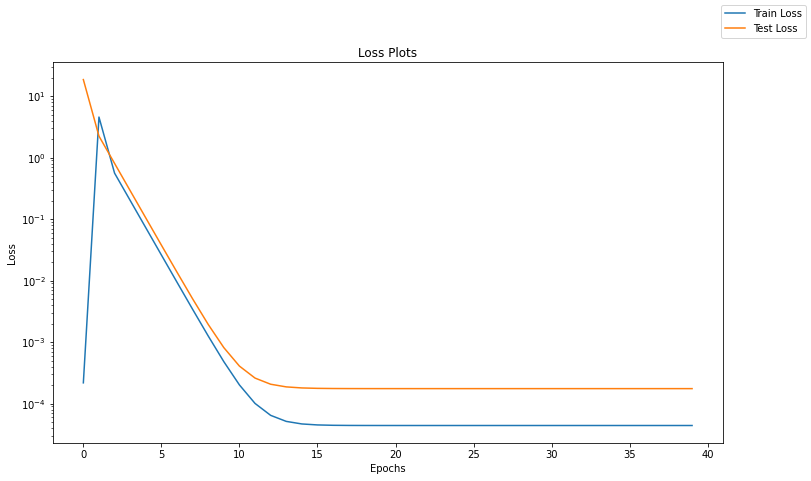

In [ ]:
extracted_df = add_extracted_features(train_df)
preprocessed_df = get_processed_df(train_df)

numeric_data = extracted_df.select_dtypes(['number']).drop(columns='id')
tfidf_sentence = get_tfidf(preprocessed_df['editedSentence'])

x = numeric_data.drop(columns=['meanGrade', 'grades']).values
x = np.concatenate((tfidf_sentence.toarray(), x), axis=1)
y = numeric_data['meanGrade'].values

# Prepare data.
training_data, dev_data, training_y, dev_y = train_test_split(x, y, test_size=(1-train_proportion),
                                                                        random_state=42)
x_train = torch.Tensor(training_data).cuda()
y_train = torch.Tensor(training_y).cuda()
x_test = torch.Tensor(dev_data).cuda()
y_test = torch.Tensor(dev_y).cuda()

# Initialise model.
net = Net(input_size=x.shape[1], hidden_size=20, output_size=1)
net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

num_epochs = 40

train_loss = []
test_loss = []

# Train the network
for t in range(num_epochs):
    tr_loss = 0
    te_loss = 0
    prediction = net(x_train)     

    tr_loss = loss_func(prediction, y_train)
    train_loss.append(tr_loss/len(x_train))

    optimizer.zero_grad()   
    tr_loss.backward()        
    optimizer.step()       
    
    with torch.no_grad():
      test_pred = net(x_test)
      te_loss = loss_func(test_pred, y_test)
      test_loss.append(te_loss/len(x_test))
   
    print("Epoch: {} | Train loss: {} | Test loss: {}".format(t+1, tr_loss/len(x_train), te_loss/len(x_test)))


fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Loss Plots')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.plot(list(range(t+1)), train_loss, label="Train Loss")
ax.plot(list(range(t+1)), test_loss, label="Test Loss")
fig.legend()

# Test
predicted_train = net(x_train).cpu().detach().numpy()
predicted_test = net(x_test).cpu().detach().numpy()
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)
print("\nDev performance:")
sse, mse = model_performance(predicted_test, dev_y, True)

FNN on additional FunLines dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# download data
funlines_train_df = pd.read_csv("/content/gdrive/MyDrive/YEAR4/NLP/data/train_funlines.csv")

In [ ]:
# Prepare FunLines dataset.
x_og, x_new, x_og_word, x_new_word = get_sentences(funlines_train_df)
y_og, y_new, y_og_word, y_new_word = get_sentences(funlines_train_df)
x_grades = funlines_train_df['meanGrade']

# Insert these new sentences into the dataframe
funlines_train_df['editedSentence'] = x_new
funlines_train_df['replaceWord'] = x_og_word

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([15969])) that is different to the input size (torch.Size([15969, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1931])) that is different to the input size (torch.Size([1931, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Train loss: 0.01633569970726967 | Test loss: 392794976.0
Epoch: 2 | Train loss: 47671104.0 | Test loss: 48524284.0
Epoch: 3 | Train loss: 5867649.0 | Test loss: 17468726.0
Epoch: 4 | Train loss: 2112353.75 | Test loss: 6288733.0
Epoch: 5 | Train loss: 760447.1875 | Test loss: 2263939.0
Epoch: 6 | Train loss: 273760.90625 | Test loss: 815015.375
Epoch: 7 | Train loss: 98553.9140625 | Test loss: 293403.84375
Epoch: 8 | Train loss: 35479.4140625 | Test loss: 105624.3984375
Epoch: 9 | Train loss: 12772.587890625 | Test loss: 38024.19921875
Epoch: 10 | Train loss: 4598.1328125 | Test loss: 13688.3544921875
Epoch: 11 | Train loss: 1655.3271484375 | Test loss: 4927.59521484375
Epoch: 12 | Train loss: 595.9178466796875 | Test loss: 1773.806640625
Epoch: 13 | Train loss: 214.5304412841797 | Test loss: 638.4938354492188
Epoch: 14 | Train loss: 77.23097229003906 | Test loss: 229.81192016601562
Epoch: 15 | Train loss: 27.803157806396484 | Test loss: 82.70486450195312
Epoch: 16 | Train l

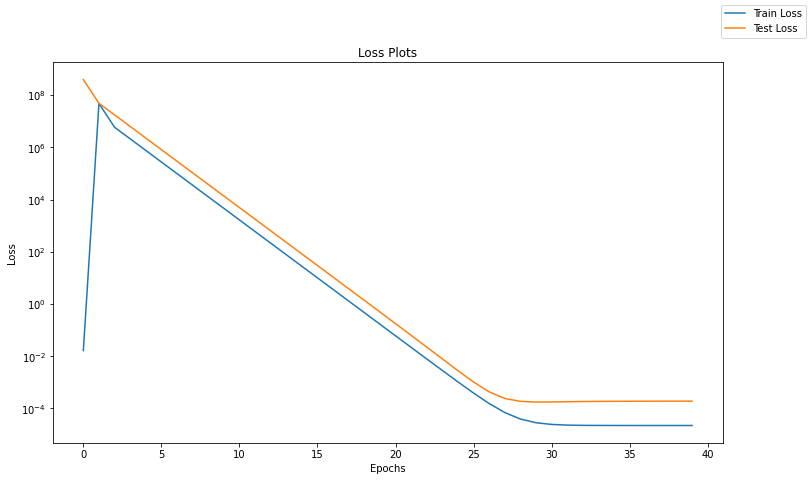

In [ ]:
orig_extracted_df = add_extracted_features(train_df)
funlines_extracted_df = add_extracted_features(funlines_train_df)

numeric_data = orig_extracted_df.select_dtypes(['number']).drop(columns='id')
funlines_numeric_data = funlines_extracted_df.select_dtypes(['number']).drop(columns='id')

x = numeric_data.drop(columns=['meanGrade', 'grades']).values
y = numeric_data['meanGrade'].values

# Prepare data.
training_data, dev_data, training_y, dev_y = train_test_split(x, y, test_size=(1-train_proportion),
                                                                        random_state=42)

# Append additional training data.
funlines_x = funlines_numeric_data.drop(columns=['meanGrade', 'grades']).values
funlines_y = funlines_numeric_data['meanGrade'].values
training_data = np.concatenate((training_data, funlines_x), axis=0)
training_y = np.concatenate((training_y, funlines_y), axis=0)

x_train = torch.Tensor(training_data).cuda()
y_train = torch.Tensor(training_y).cuda()
x_test = torch.Tensor(dev_data).cuda()
y_test = torch.Tensor(dev_y).cuda()

# Initialise model.
net = Net(input_size=x.shape[1], hidden_size=20, output_size=1)
net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

num_epochs = 40

train_loss = []
test_loss = []

# Train the network
for t in range(num_epochs):
    tr_loss = 0
    te_loss = 0
    prediction = net(x_train)     

    tr_loss = loss_func(prediction, y_train)
    train_loss.append(tr_loss/len(x_train))

    optimizer.zero_grad()   
    tr_loss.backward()        
    optimizer.step()       
    
    with torch.no_grad():
      test_pred = net(x_test)
      te_loss = loss_func(test_pred, y_test)
      test_loss.append(te_loss/len(x_test))
   
    print("Epoch: {} | Train loss: {} | Test loss: {}".format(t+1, tr_loss/len(x_train), te_loss/len(x_test)))


fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Loss Plots')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.plot(list(range(t+1)), train_loss, label="Train Loss")
ax.plot(list(range(t+1)), test_loss, label="Test Loss")
fig.legend()

# Test
predicted_train = net(x_train).cpu().detach().numpy()
predicted_test = net(x_test).cpu().detach().numpy()
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)
print("\nDev performance:")
sse, mse = model_performance(predicted_test, dev_y, True)

### Baseline

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:


TypeError: ignored

# Analysis
Here we perform some analysis on the data distribution to see if there is any significant features that can be handcrafted and added to the training of the model.

## Sentence Statistics

### Grade distribution

In [ ]:
grades = train_df['meanGrade']
print("Mean grade: {}".format(grades.mean()))
bins = np.arange(-0.1, 3.1, 0.1)
print("bins: {}".format(bins))

grade_counts = grades.value_counts(bins=bins, sort=False)
grade_counts.plot(figsize=(10,8), title="Grade Counts", kind="bar", xlabel="Grade", ylabel="Counts")

### Word/Character Count/Length Distribution

In [ ]:
# Create new grade bins.
category_bins = np.arange(-0.1, 3.5, 0.5)
train_df['gradeCategory'] = pd.cut(train_df['meanGrade'], bins=category_bins, labels=["<0.5", "<1.0", "<1.5", "<2.0", "<2.5", "<3.0", "3.0"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
train_df.groupby(['meanGrade']).mean()['avgWordLength'].plot(title="Average Sentence Word Length by Grade", ylabel="avgWordLength", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['avgWordLength'].plot(title="Average Sentence Word Length by Grade", ylabel="avgWordLength", ax=axes[1])

### Stop word Analysis

In [ ]:
train_df.groupby(['meanGrade']).mean()['numStopWords'].plot(title="Average numStopWords by Grade", ylabel="numStopWords", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numStopWords'].plot(title="Average numStopWords by Grade", ylabel="numStopWords", ax=axes[1])

### Word type analysis

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
train_df.groupby(['meanGrade']).mean()['numHashtags'].plot(title="Average numHashtags by Grade", ylabel="numHashtags", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numHashtags'].plot(title="Average numHashtags by Grade", ylabel="numHashtags", ax=axes[1])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
train_df.groupby(['meanGrade']).mean()['numDigits'].plot(title="Average numDigits by Grade", ylabel="numDigits", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numDigits'].plot(title="Average numDigits by Grade", ylabel="numDigits", ax=axes[1])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
train_df.groupby(['meanGrade']).mean()['numUpperCase'].plot(title="Average numUpperCase by Grade", ylabel="numUpperCase", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numUpperCase'].plot(title="Average numUpperCase by Grade", ylabel="numUpperCase", ax=axes[1])

## Text Analysis

In [ ]:
# Get set of replacement words.
replacement_words = train_df['edit']
print(replacement_words.value_counts())
print("Num replaced words == 'trump': {}".format(len(train_df[train_df['edit'] == 'trump'])))
print("Mean grade of replaced words == 'party': {}".format(train_df[train_df['edit'] == 'party'].mean()['meanGrade']))
print("Mean grade of replaced words == 'hair': {}".format(train_df[train_df['edit'] == 'hair'].mean()['meanGrade']))
print("Mean grade of replaced words == 'dance': {}".format(train_df[train_df['edit'] == 'dance'].mean()['meanGrade']))
print("Mean grade of replaced words == 'dancing': {}".format(train_df[train_df['edit'] == 'dancing'].mean()['meanGrade']))
print("Mean grade of replaced words == 'circus': {}".format(train_df[train_df['edit'] == 'circus'].mean()['meanGrade']))

In [ ]:
# Funniest sentence.
train_df.loc[train_df['meanGrade'].idxmax()]

In [ ]:
# Find common words.
freq = pd.Series(' '.join(processed['editedSentence']).split()).value_counts()
top_freq = freq[:10]
top_freq

In [ ]:
# Find rare words.
bottom_freq = freq[-10:]
bottom_freq

In [ ]:
# We cannot delete the most/least common words because they are the edited words.
print("Least common words that are replacement words: {}".format(set.intersection(set(bottom_freq.index.tolist()), set(replacement_words.values.tolist()))))
print("Most common words that are replacement words: {}".format(set.intersection(set(top_freq.index.tolist()), set(replacement_words.values.tolist()))))

In [ ]:
# Plot the feature correlation
import seaborn as sns
corr = numeric_data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})